In [3]:
from model import *
from utils import *

BATCH_SIZE = 256
LR = 1e-3
MAX_EPOCHS = 50

In [ ]:
multiSet = MultiSet('pokemon')
dataLoader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=1)

for i, data in enumerate(dataLoader):
    if i in range(5):
        plt.imshow(data[0,:,:,:].squeeze().numpy())
        plt.show()

In [ ]:
gen_data_list()
multiSet = MultiSet('pokemon')
dataloader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=BATCH_SIZE)

for _ in range(min_lr, max_lr, step):
    for images in dataloader:
        optimizer.zero_grad()

        image_in = images.permute(0,3,1,2)
        x_in = Variable(image_in.float().cuda())

        x_out, z_mu, z_logvar = model(x_in)

        loss, bce, kl = criterion(x_out, x_in, z_mu, z_logvar)
        loss.backward()
        scheduler.step()
        optimizer.step()
        losses.append(loss.item())
        bces.append(bce.item())
        kls.append(kl.item())

    epoch += 1


In [ ]:
try:
    net, epoch, losses, bces, kls, optimizer, scheduler = load_checkpoint("./checkpoints/", LR)
except:
    net = Net() # Initialize model
    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            net = torch.nn.DataParallel(net)
        net = net.cuda() 
    epoch = 0
    losses = []
    bces = []
    kls = []
    optimizer = optim.Adam(net.parameters(), lr=LR, amsgrad=True)
    scheduler = SGDRScheduler(optimizer, min_lr=1e-5, max_lr=LR, cycle_length=500, current_step=0)
    print("Starting new training")

gen_data_list()
multiSet = MultiSet('pokemon')
dataloader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=BATCH_SIZE)

train_losses, bces, kls = train(net, optimizer, scheduler,dataloader, epoch, "POKEVAE", losses, bces, kls, MAX_EPOCHS)
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(bces)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(kls)
plt.show()

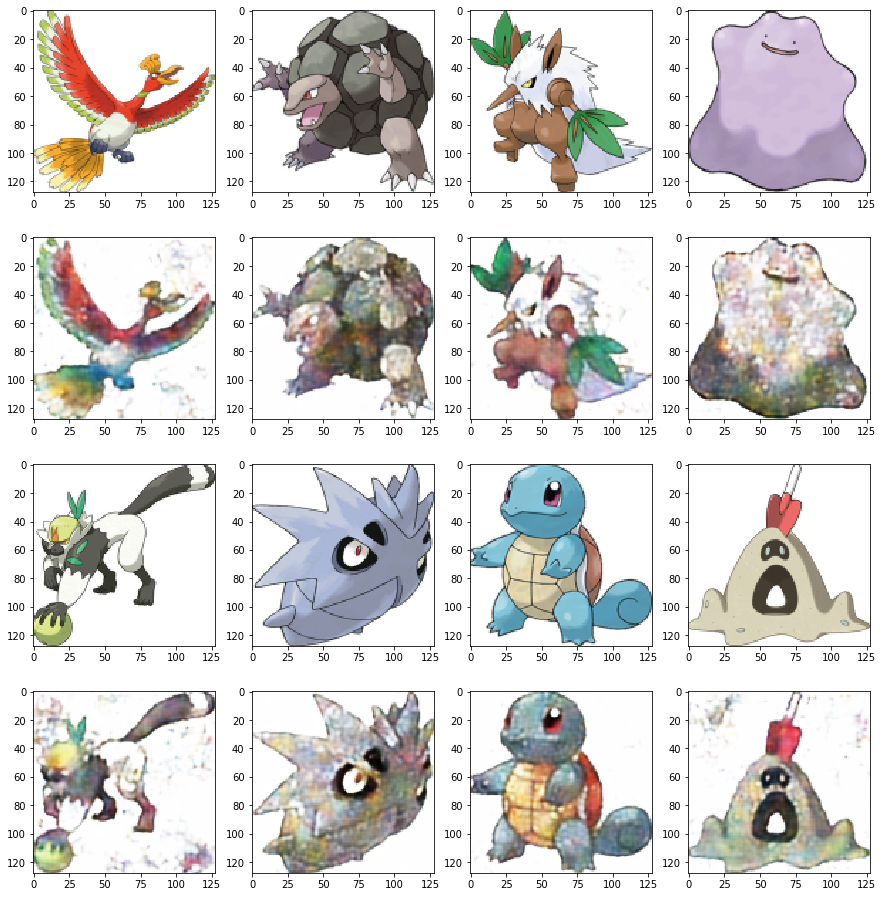

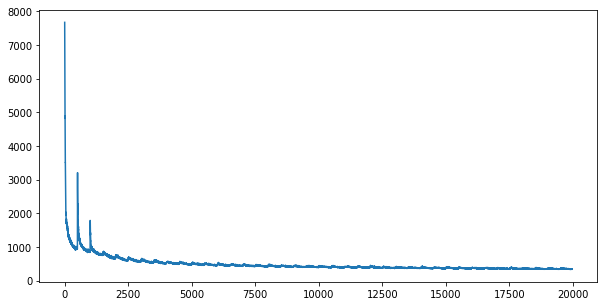

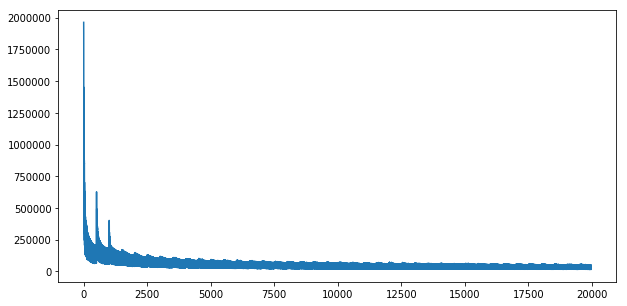

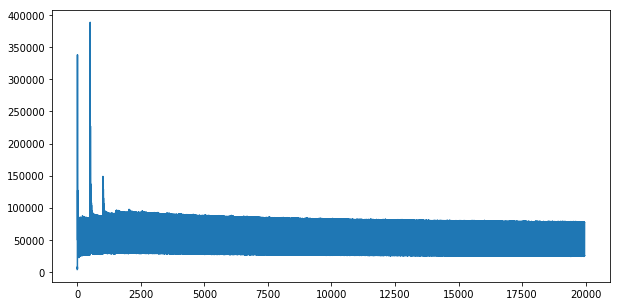

In [6]:
try:
    net, epoch, losses, bces, kls, optimizer, scheduler = load_checkpoint("./checkpoints/VAE_epoch_004990.pth", LR)
except:
    raise

gen_data_list()
multiSet = MultiSet('pokemon')
dataLoader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=BATCH_SIZE)

for images in dataLoader:
    clear_output(wait=True)
    multi_plot(images, net)
    break
    
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(bces)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(kls)
plt.show()

In [2]:
try:
    net, epoch, losses, bces, kls, optimizer, scheduler = load_checkpoint("./checkpoints/VAE_epoch_004990.pth", LR)
except:
    raise

gen_data_list()
multiSet = MultiSet('pokemon')
dataLoader = Utils.DataLoader(dataset=multiSet, shuffle=True, batch_size=1)

for images in dataLoader:
    sweep(net, images, 99, -15, 15, 1)
    break

Loaded checkpoint: ./checkpoints/VAE_epoch_004990.pth
Pokemon image list available


ValueError: Floating point image RGB values must be in the 0..1 range.

In [ ]:
# Visualize moving average of losses
def visualize_losses_moving_average(losses,window=50,boundary='valid'):
    mav_losses = np.convolve(losses,np.ones(window)/window,boundary)
    corrected_mav_losses = np.append(np.full(window-1,np.nan),mav_losses)
    plt.figure(figsize=(10,5))
    plt.plot(losses)
    plt.plot(corrected_mav_losses)
    plt.ylim(ylim)
    plt.show()

visualize_losses_moving_average(train_losses)

In [ ]:
#Test network accuracy

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs, _, _ = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
imageimage  ==  imageimage..permutepermute(0,2,3,1)
for i in range(256):
    os.system("mkdir ./sweep/"+str(i))
    sweep(image, i, -300, 300, 5)

In [ ]:
def interpolate_linear(path1, path2, savepath, STEP):
    pokemon = mpimg.imread(path1)
    pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
    pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
    image = torch.from_numpy(pokemon).unsqueeze(0)

    image = image[0,:,:,:].unsqueeze(0)
    image = image.permute(0,3,1,2)
    z_mean, z_logvar = net.encoder(Variable(image.float()).cuda())
    z1 = net.latent(z_mean, z_logvar)
    ss = net.decoder(z1)
    ss = ss.permute(0,2,3,1)
    plt.imshow(ss.data.cpu().squeeze().numpy())
    plt.show()

    pokemon = mpimg.imread(path2)
    pokemon = cv2.resize(pokemon, (RESIZE,RESIZE))
    pokemon = (pokemon - np.min(pokemon))/np.max(pokemon - np.min(pokemon))
    image = torch.from_numpy(pokemon).unsqueeze(0)

    image = image[0,:,:,:].unsqueeze(0)
    image = image.permute(0,3,1,2)
    z_mean, z_logvar = net.encoder(Variable(image.float()).cuda())
    z2 = net.latent(z_mean, z_logvar)
    ss = net.decoder(z2)
    ss = ss.permute(0,2,3,1)
    plt.imshow(ss.data.cpu().squeeze().numpy())
    plt.show()
    step = (z2-z1)/STEP

    for i in range(STEP):
        ss = net.decoder(z1 + i*step)
        ss = ss.permute(0,2,3,1)
        plt.imsave(savepath + "{0:03d}".format(i) + ".png", ss.data.cpu().squeeze().numpy())

In [ ]:
STEP  ==  100
interpolate_linearinterpo ("./Pokemon/squirtle.jpg", "./Pokemon/charmander.jpg", "./interpolate/squirtle_charmander/", STEP)